In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Tensorflow-Keras packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44091 sha256=3773c5009b977eaf4547a509fa906370ab07f5f870acf5655e73e5dd41597ce0
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.4.1 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
dask 2023.5.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
dask-cuda 23.4.0 requires dask==2023.3.2, but you have dask 2023.5.0 which is incom

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

[07/16 17:23:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:01, 163MB/s]                             


## detectron label:
1. {0: u'__background__',
1: u'person',
2: u'bicycle',
 3: u'car',
 4: u'motorcycle',
 5: u'airplane',
 6: u'bus',
 7: u'train',
 8: u'truck',
 9: u'boat',
 10: u'traffic light',
 11: u'fire hydrant',
 12: u'stop sign',
 13: u'parking meter',
 14: u'bench',
 15: u'bird',
 16: u'cat',
 17: u'dog',
 18: u'horse',
 19: u'sheep',
 20: u'cow',
 21: u'elephant',
 22: u'bear',
 23: u'zebra',
 24: u'giraffe',
 25: u'backpack',
 26: u'umbrella',
 27: u'handbag',
 28: u'tie',
 29: u'suitcase',
 30: u'frisbee',
 31: u'skis',
 32: u'snowboard',
 33: u'sports ball',
 34: u'kite',
 35: u'baseball bat',
 36: u'baseball glove',
 37: u'skateboard',
 38: u'surfboard',
 39: u'tennis racket',
 40: u'bottle',
 41: u'wine glass',
 42: u'cup',
 43: u'fork',
 44: u'knife',
 45: u'spoon',
 46: u'bowl',
 47: u'banana',
 48: u'apple',
 49: u'sandwich',
 50: u'orange',
 51: u'broccoli',
 52: u'carrot',
 53: u'hot dog',
 54: u'pizza',
 55: u'donut',
 56: u'cake',
 57: u'chair',
 58: u'couch',
 59: u'potted plant',
 60: u'bed',
 61: u'dining table',
 62: u'toilet',
 63: u'tv',
 64: u'laptop',
 65: u'mouse',
 66: u'remote',
 67: u'keyboard',
 68: u'cell phone',
 69: u'microwave',
 70: u'oven',
 71: u'toaster',
 72: u'sink',
 73: u'refrigerator',
 74: u'book',
 75: u'clock',
 76: u'vase',
 77: u'scissors',
 78: u'teddy bear',
 79: u'hair drier',
 80: u'toothbrush'

In [7]:
!wget https://c8.alamy.com/zooms/9/713ab245ae9143c9a235293a760c7ca6/prx65a.jpg

--2023-07-16 17:24:47--  https://c8.alamy.com/zooms/9/713ab245ae9143c9a235293a760c7ca6/prx65a.jpg
Resolving c8.alamy.com (c8.alamy.com)... 54.183.116.71, 54.176.229.84
Connecting to c8.alamy.com (c8.alamy.com)|54.183.116.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘prx65a.jpg’

prx65a.jpg              [ <=>                ]  28.83K  --.-KB/s    in 0.05s   

Last-modified header invalid -- time-stamp ignored.
2023-07-16 17:24:47 (605 KB/s) - ‘prx65a.jpg’ saved [29519]



In [3]:
model_path = '/kaggle/input/model-food-detection/foodDetection.h5'
model = tf.keras.models.load_model(model_path)

classes = ['burger',
 'butter_naan',
 'chai',
 'chapati',
 'chole_bhature',
 'dal_makhani',
 'dhokla',
 'fried_rice',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'momos',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'pizza',
 'samosa']

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow.keras.preprocessing.image as keras_image
from PIL import Image


def segimage(img_path):
    im = cv2.imread(img_path)

    outputs = predictor(im)
    
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    a = out.get_image()[:, :, ::-1]
    # Convert the image from BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Remove axis ticks and labels
    plt.show()
    
    return outputs["instances"].pred_classes , outputs["instances"].pred_boxes



def processImage(img,IMG_SIZE = (256 , 256)):
    if type(img) == str:
        raw_img = keras.preprocessing.image.load_img(img, target_size=IMG_SIZE)
        img_array = keras.preprocessing.image.img_to_array(raw_img)

        # Reshaping
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis

        img_array.shape
        # Make predictions
        predictions = model.predict(img_array)
        a = np.argmax(predictions)
        series= pd.Series(predictions[0], index=classes)
        print(classes[a] , series[a]*100)
        return classes[a] , series[a]
    else:

        # Assuming you have a matrix representing the image called 'image_matrix'
        image_matrix = img
        
        image = Image.fromarray(image_matrix.astype('uint8'))
        resized_image = image.resize(IMG_SIZE)

        # Convert the resized image to a NumPy array
        resized_array = keras_image.img_to_array(resized_image)
        plt.imshow(resized_array)
        # Reshaping
        img_array = tf.expand_dims(resized_array, 0)  # Create batch axis
        
        # Make predictions
        predictions = model.predict(img_array)
        a = np.argmax(predictions)
        series= pd.Series(predictions[0], index=classes)
        print(classes[a] , series[a]*100)
        return classes[a] , series[a]
    

def show_items(labels , boxes, im):
    a = []
    for idx,i in enumerate(list(labels)):
        label = i.item()
        print(idx)
        if (label >= 40 and label <=50):
            # this means a bowl image
            bb = boxes[idx]
            bb = bb.tensor.tolist()[0]
            x1, y1, x2, y2 = bb
            # Crop the image using the bounding box coordinates
            image_cropped = im[int(y1):int(y2), int(x1):int(x2)]
            
            image_cropped = cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB)
            foodItem , probability = processImage(image_cropped)
            
            plt.title(foodItem)
            plt.imshow(image_cropped)

             #--------------------------------> this function

            plt.axis('off')  # Remove axis ticks and labels
            plt.show()
            a.append(foodItem)
    
    return a

In [5]:
def Inference(img_path):
    labels , boxes = segimage(img_path)
    im = cv2.imread(img_path)
    return show_items(labels , boxes , im)
    

In [75]:
!wget https://live.staticflickr.com/5049/5339143096_b500d72ef5_b.jpg

--2023-07-16 15:39:51--  https://live.staticflickr.com/5049/5339143096_b500d72ef5_b.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 18.67.113.81, 2600:9000:209b:4a00:0:5a51:64c9:c681, 2600:9000:209b:4e00:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|18.67.113.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘5339143096_b500d72ef5_b.jpg’

5339143096_b500d72e     [ <=>                ] 193.71K  --.-KB/s    in 0.004s  

2023-07-16 15:39:51 (46.2 MB/s) - ‘5339143096_b500d72ef5_b.jpg’ saved [198363]



In [13]:
!wget https://t4.ftcdn.net/jpg/00/68/98/95/360_F_68989589_WTDktYlqI3pCnSXYH2ja0DPn4wdg0DwN.jpg

--2023-07-16 17:27:33--  https://t4.ftcdn.net/jpg/00/68/98/95/360_F_68989589_WTDktYlqI3pCnSXYH2ja0DPn4wdg0DwN.jpg
Resolving t4.ftcdn.net (t4.ftcdn.net)... 151.101.1.167, 151.101.65.167, 151.101.129.167, ...
Connecting to t4.ftcdn.net (t4.ftcdn.net)|151.101.1.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68850 (67K) [image/jpeg]
Saving to: ‘360_F_68989589_WTDktYlqI3pCnSXYH2ja0DPn4wdg0DwN.jpg’

360_F_68989589_WTDk 100%[===================>]  67.24K  --.-KB/s    in 0.01s   

2023-07-16 17:27:33 (5.62 MB/s) - ‘360_F_68989589_WTDktYlqI3pCnSXYH2ja0DPn4wdg0DwN.jpg’ saved [68850/68850]



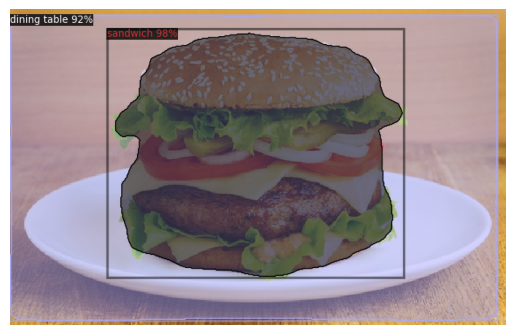

0
1/1 [==============================] - 0s 24ms/step
burger 98.22874665260315


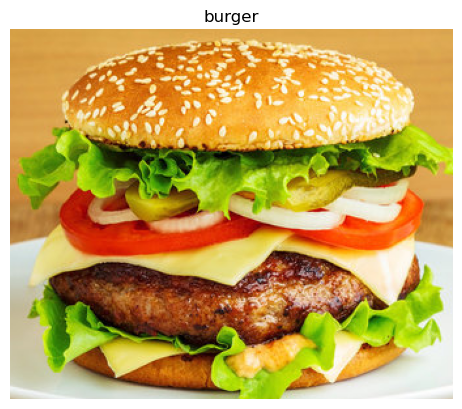

1


In [14]:
img_path = '/kaggle/working/360_F_68989589_WTDktYlqI3pCnSXYH2ja0DPn4wdg0DwN.jpg'
list_res = Inference(img_path)

In [18]:
# get nutrients detail from the food 
# there is no good api as such but still

import requests

api_key = "3216ee8782msh415af6cdccxxxxxxxx16e734jsn1b8f9dff6374"

url = "https://dietagram.p.rapidapi.com/apiFood.php"
headers = {
        "X-RapidAPI-Key": api_key,
        "X-RapidAPI-Host": "dietagram.p.rapidapi.com"
    }

total_cals = 0


for item in list_res:
    querystring = {"name":item,"lang":"pl"}

    response = requests.get(url, headers=headers, params=querystring)

    resp = response.json()
    
    a = int(resp['dishes'][0]['caloric'])
    print('You are about to eat',item ,'which has', a, 'Calories')    
    total_cals = total_cals + a
    



You are about to eat burger which has 179 Calories


# Done !!! 